<DIV ALIGN=CENTER>

# Introduction to Probabilistic Programming
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we introduce probabilistic programming by
employing Bayesian model fitting. The Bayesian approach uses
observations or data, to modify prior assumptions, which produces
posterior distributions for our model parameters. In this manner, we not
only obtain the best model parameters but also probability density
functions for these parameters (which provides robust error estimation).
To compute the model likelihoods and the posterior distributions, we will
employ the pymc3 library.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

### Sample Model

We begin by creating a sample data set that we will analyze by using
Bayesian Modeling. The model we use to create the data is similar to
the original linear regression model first introduced in Week One.
Following the model definition, we sample data from this model and plot
the result by using the Seaborn library's regression plot (`regplot`)
method, which in this case displays the best fit regression line. The
technique used in this plot is a frequentist method, which provides a
counterpart to the Bayesian technique we develop in this Notebook.


-----

In [2]:
# We define a simple function to fit.

m_true = 0.5
b_true = 0.25

np.random.seed(23)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = b_true + m_true * x - sigma * np.random.randn(len(x))

    return(x, y)

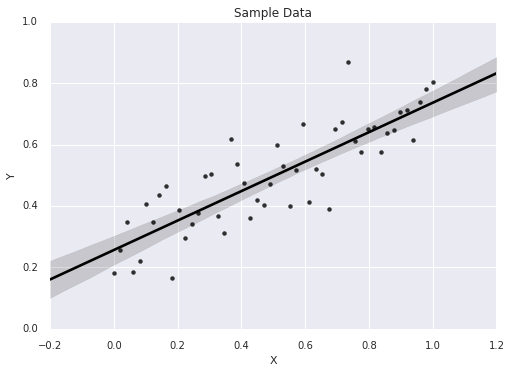

In [3]:
# Obtain sample data and plot data and model fit

x, y = theModel(num = 50)

ax = sns.regplot(x, y, fit_reg=True, color='black', label="Data")
ax.set(xlabel='X', ylabel='Y', title='Sample Data')
sns.despine(offset=5, trim=True)

-----

We also can use the statsmodel library to perform an ordinary linear
regression, as introduced in Week Two, to obtain a model fit along with
fit statistics. In particular, this method provides values for our model
parameters along with an estimated error (in this case the slope and
intercept of the linear model being used).

-----

In [4]:
import statsmodels.formula.api as smf

# Encapsulate our test data
df = pd.DataFrame({'x': x, 'y': y})

# Implement simple regression: Result ~ Input

# First we fit slope and intercept
result = smf.ols(formula='y ~ x', data=df).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     116.3
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.01e-14
Time:                        17:16:22   Log-Likelihood:                 49.021
No. Observations:                  50   AIC:                            -94.04
Df Residuals:                      48   BIC:                            -90.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2567      0.026      9.944      0.000         0.205     0.309
x              0.4798      0.044     10.786      0.000         0.390     0.569
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.782
Skew:                           0.303   Prob(JB):                        0.676
Kurtosis:                       3.095   Cond. No.                         4.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----

### Bayesian Analysis

These previous approaches to modeling a data set employed _frequentist_
techniques, where data are used to approximate the unknown model
parameters. An alternative approach employs Bayesian statistics, where
data are used to infer the likelihood distribution for the unknown model
parameters. In this case, the probabilities encapsulate our _belief_
that the model parameters take on specific values. Simply put, the
Bayesian approach uses data to modify our prior beliefs. While
conceptually powerful, broad adoption of Bayesian approaches has been
limited in the past by the computational difficulties in computing these
likelihoods. However, we can now use the pymc library to simplify this
process. 

In the next few code cells, we import the pymc3 library, create a model
context, define our model parameters, and compute the likelihood. In this
initial example, we assume our prior on the intercept is uniform between
0 and 1, while our prior on the slope is normally distributed about the
line `y = x` with a standard deviation of one. Next we model our likelihood
as a normal distribution, where the mean value is our expected value
from the linear model, and the standard deviation is another normally
distributed deviate.

-----

In [5]:
# The following example follows the first case study from pymc3 documentation
# http://pymc-devs.github.io/pymc3/getting_started/#case-study-1-stochastic-volatility

import pymc3 as pm

In [6]:
n_samples = 10000

with pm.Model() as linear_model:
    
    # First, define stohastic model variables
    intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
    slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('sigma', mu = 1., sd = 2.0) #beta=10, testval=1.)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept + slope* x
    
    # Sample values (likelihood)
    likelihood = pm.Normal('y', mu=y_exp, sd=sigma, observed=y)

Applied interval-transform to Intercept and added transformed Intercept_interval_ to model.


-----

### Prior Visualization

We can visualize our prior beliefs, by computing the probability density
functions for both the slope and intercept, as shown in the next code
cell.

-----

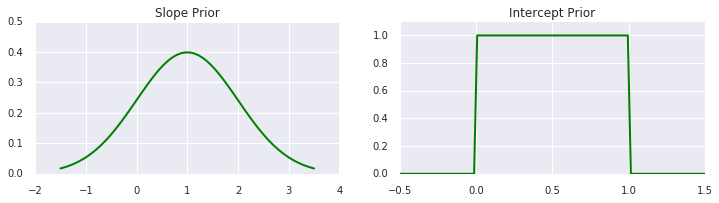

In [7]:
import scipy.stats as sts

# Compute and plot slope prior
plt.figure(figsize=(12, 6))
plt.subplot(221)
x_pts = np.linspace(-1.5, 3.5, 100)
rv = sts.norm(loc=1.0, scale=1.0)
plt.plot(x_pts, rv.pdf(x_pts), 'g-', lw=2)
plt.ylim(0.0, 0.5)
plt.title('Slope Prior')

# Compute and plot interecpt prior
plt.subplot(222)
x_pts = np.linspace(-0.5, 1.5, 100)
rv = sts.uniform(loc=0.0, scale=1.0)
plt.plot(x_pts, rv.pdf(x_pts), 'g-', lw=2)
plt.title('Intercept Prior')
plt.ylim(0.0, 1.1)
sns.despine(offset=5, trim=True)
plt.show()

-----

### Sample Posterior

Given our priors and a method for sampling the likelihood of different 
model parameters, the next step is define a mechanism for computing
model likelihoods as we move around in the parameter space defined by our
chosen model (in this case the two-dimensional slope-intercept space).
The standard approach for computing these quantities is known as Markov
Chain Monte Carlo (MCMC). The pymc3 library provides several different
MCMC techniques, the sampler we demonstrate in this first example is the
No U-Turn Sampler (or NUTS), which is a Hamiltonian MCMC sampler that is
fairly robust. Another frequently used sampler is the Metropolis sampler. 

Once the sampler has been created, we can use it to create a chain of
sampled parameter values, which are known as _traces_. After a (large)
number of samples have been generated, these traces will provide
posterior distributions for the model parameters. Thus, we can use the
traces to not only obtain the model parameter values, but a statistical
characterization for these values. 

-----

In [8]:
# Define MCMC sampling technique.
step = pm.NUTS(model = linear_model)

In [9]:
# Use MCMC sampler to generate model traces
trace = pm.sample(n_samples, step, 
                  model = linear_model,
                  progressbar = True)

 [-----------------100%-----------------] 10000 of 10000 complete in 15.0 sec

-----

### Trace Analysis

The trace for a given parameter provides a statistical characterization
of that parameter given the data. In the next several code cells, we
demonstrate different techniques for analyzing traces. First, we create
a DataFrame for the different traces, and subsequently compute statistical
summaries for the two traces of interest (i.e., the slope and the
intercept). Next, we graphically display the trace for these two
quantities, which demonstrates how the trace fluctuates around a most
likely value.

Note that, while not the case in this example, the traces often take a
while to settle down to the vicinity of the most likely values. This
period is known as _burn-in_ and is generally handled by simply
discarding some initial fraction of the overall samples. Standard
practice varies on the problem domain, but typical values of the burn-in
range from several thousand samples to nearly fifty percent of the total
samples.

-----

In [10]:
df_trace = pm.trace_to_dataframe(trace)
df_trace[['Intercept', 'Slope']].describe()

,Intercept,Slope
count,10000.000000,10000.000000
mean,0.255859,0.481786
std,0.027290,0.047110
min,0.166217,0.320265
25%,0.237853,0.451247
50%,0.255861,0.480522
75%,0.273702,0.512474
max,0.492116,1.020561


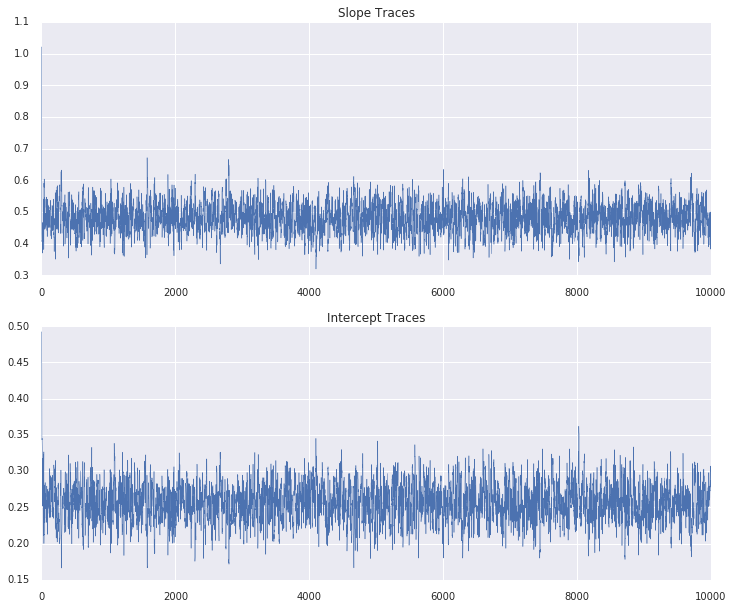

In [11]:
plt.figure(figsize=(12, 10))
sns.set_style('darkgrid')

plt.subplot(211)
plt.plot(df_trace['Slope'], lw=0.5)
plt.title('Slope Traces')

plt.subplot(212)
plt.plot(df_trace['Intercept'], lw=0.5)
plt.title('Intercept Traces')
sns.despine(offset = 5, trim=False)
plt.show()

-----

### Posterior Distributions

The traces, especially after removing any samples that are part of the
_burn-in_ are the distributions of the model parameter values, or the
Posterior of our Bayesian calculation. We can compute statistical
summaries from the traces, and also plot their distributions, as shown
in the following two code cells. In both examples, we discard the first
1000 (via the `n_burn` parameter) traces as the burn-in phase.

-----

In [12]:
# Compute model parameter statistics from the traces

n_burn = 1000

print('Slope Trace Values:')
print(trace['Slope'][-10:])

print('\nSlope Trace  statistics:')
mu = np.mean(trace['Slope']) ; sigma = np.std(trace['Slope'])
print('Full Sample:  Mean = {0:4.3f}, STD = {1:4.3f}'.format(mu, sigma))
mu = np.mean(trace['Slope'][-n_burn:]) ; sigma = np.std(trace['Slope'][-n_burn:])
print('Last {0}:  Mean = {1:4.3f}, STD = {2:4.3f}'.format(n_burn, mu, sigma))

print('\nIntercept Trace Values:')
print(trace['Intercept'][-10:])

print('\nIntercept Trace statistics:')
mu = np.mean(trace['Intercept']) ; sigma = np.std(trace['Intercept'])
print('Full Sample:  Mean = {0:4.3f}, STD = {1:4.3f}'.format(mu, sigma))
mu = np.mean(trace['Intercept'][-n_burn:]) ; sigma = np.std(trace['Intercept'][-n_burn:])
print('Last {0}:  Mean = {1:4.3f}, STD = {2:4.3f}'.format(n_burn, mu, sigma))

Slope Trace Values:
[ 0.38847215  0.38295306  0.50018026  0.50018026  0.45326908  0.45326908
  0.42957995  0.46170257  0.45857399  0.46432911]

Slope Trace  statistics:
Full Sample:  Mean = 0.482, STD = 0.047
Last 1000:  Mean = 0.483, STD = 0.042

Intercept Trace Values:
[ 0.29159139  0.29098663  0.27803893  0.27803893  0.28159371  0.28159371
  0.28731943  0.2746595   0.27259467  0.27327472]

Intercept Trace statistics:
Full Sample:  Mean = 0.256, STD = 0.027
Last 1000:  Mean = 0.256, STD = 0.025


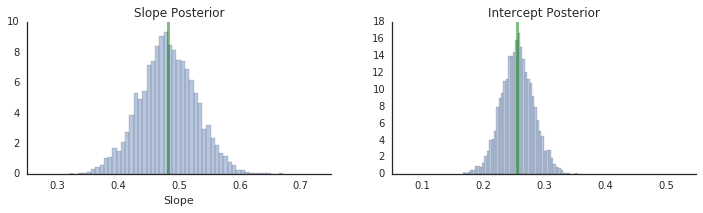

In [13]:
# Visualize the trace statistics

plt.figure(figsize=(12, 6))
sns.set_style('white')

plt.subplot(221)
sns.distplot(df_trace['Slope'][n_burn:], kde=False, norm_hist=True, bins=50)

mu = np.mean(df_trace['Slope'][n_burn:])
plt.axvline(mu, linestyle='-', color='g', lw = 3, alpha=0.5)

plt.xlim(0.25, 0.75)
plt.title('Slope Posterior')

plt.subplot(222)
sns.distplot(trace['Intercept'][n_burn:], kde=False, norm_hist=True, bins=50)

mu = np.mean(df_trace['Intercept'][n_burn:])
plt.axvline(mu, linestyle='-', color='g', lw = 3, alpha=0.5)

plt.xlim(0.05, 0.55)
plt.title('Intercept Posterior')
sns.despine()
plt.show()


-----

### Visualizing the Posterior Density

We can visualize the two-dimensional posterior in our model parameter
space, which provides the joint probability. In the following code cell,
we use our DataFrame to make a kernel density estimate plot of the
posterior density in the slope-intercept parameter space.

-----

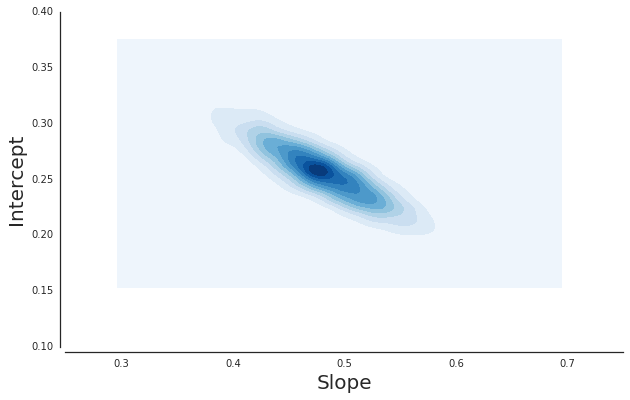

In [14]:
# Visualize Posterior density

plt.figure(figsize=(10, 6))
sns.set_style('white')
sns.kdeplot(df_trace.Slope[n_burn:], df_trace.Intercept[n_burn:], cmap='Blues', shade=True)
plt.xlabel('Slope', fontsize=20)
plt.xlim(0.25, 0.75)
plt.ylabel('Intercept', fontsize=20)
plt.ylim(0.1, 0.4)

sns.despine(offset=5, trim=False)
plt.show()

-----

### Autocorrelation

The sampling should be a stochastic process, thus, after a small lag,
there should be no correlation between samples. We can test this by
computing and visualizing the autocorrelation of trace samples. in the
following code cell, we compute the autocorrelation of the slope and
intercept traces. After around a lag of 20, the traces show minimal or no
correlation (i.e. they fluctuate around zero), which is a desired
feature.

-----

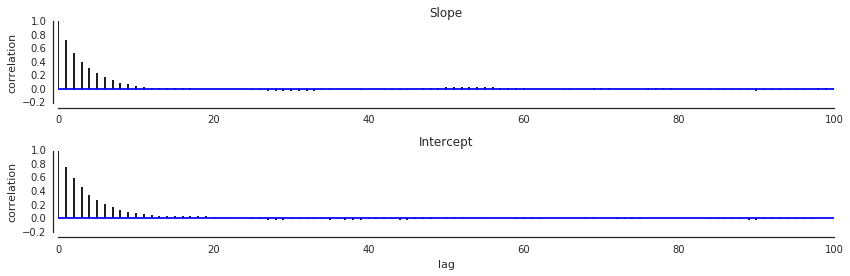

In [15]:
# Visualize the autocorrelations

sns.set_style('white')

pm.autocorrplot(trace, varnames=['Slope', 'Intercept'])
sns.despine(offset=5, trim = True)
plt.tight_layout()

-----

## PYMC3 : Bayesian Model Fitting

Previously, we performed the Bayesian model fitting across several code
cells in order to demonstrate the individual steps. Typically, however,
the entire model fitting will be performed in a single pass, as
demonstrated below. In this example, we perform the same model fitting,
with the additional explicit computation of the maximum a posteriori
estimation point. This function estimates a _good_ starting point for
the sampler, which should reduce the length of the burn_in phase and
should also help to achieve faster convergence.

Following the model fitting, we introduce several pymc3 helper functions
to simplify the visualization of the traces and posterior distributions
(via the `traceplot` method) as well as provide  a statistical summary
of the trace distributions (via the `summery` method). Finally, we
compare the data, the true regression line, a number of lines
corresponding to different trace samples, and the best model fit line.

-----

In [16]:
# Full model n_burn = 10000
n_samples = 20000

with pm.Model() as linear_model:
    
    # First, define stohastic model variables
    intercept = pm.Uniform('Intercept', lower = 0, upper = 1)
    slope = pm.Normal('Slope', mu = 1.0, sd = 1.0)
        
    # Now define stochastic variable for observation errors.    
    sigma = pm.Normal('sigma', mu = 1., sd = 2.0) #beta=10, testval=1.)

    # Expected values using original indepedent variables
    # Deterministic Variable
    y_exp =  intercept + slope* x
    
    # Sample values (likelihood)
    likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(n_samples, step=step, start=start)

Applied interval-transform to Intercept and added transformed Intercept_interval_ to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 13.7 sec

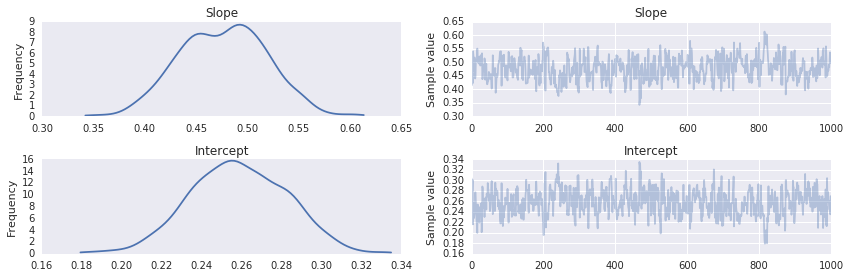

In [17]:
# Plot traces
sns.set_style('darkgrid')
pm.traceplot(trace[-n_burn:], ['Slope', 'Intercept'])
plt.show()

In [18]:
# Show trace summaries
pm.summary(trace[-n_burn:], ['Slope', 'Intercept'])


Slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.477            0.042            0.002            [0.402, 0.557]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.397          0.446          0.480          0.507          0.555


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.259            0.024            0.001            [0.213, 0.304]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.213          0.242          0.258          0.276          0.303



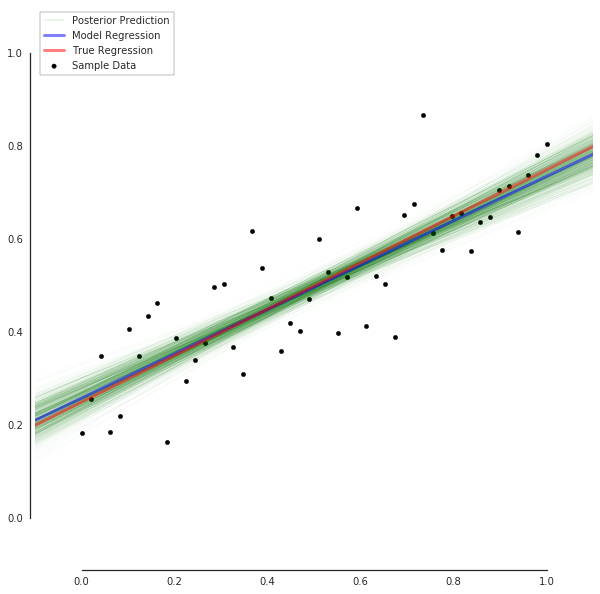

In [19]:
# Plot fits and data, only last n_smpls traces are used.
n_smpls = 1000

sns.set_style('white')
plt.figure(figsize=(10, 10))

plt.scatter(x, y, c='k', label = 'Sample Data')

xl = -0.25 ; xh = 1.25

for m, b in zip(trace['Slope'][-n_smpls:], trace['Intercept'][-n_smpls:]):
    yl = m * xl + b ; yh = m * xh + b
    plt.plot((xl, xh), (yl, yh), color='g', lw=0.15, alpha = 0.1)

# Replot last one to get legend label
plt.plot((xl, xh), (yl, yh), color='g', lw=0.15, \
         label = 'Posterior Prediction')

m_fit = trace['Slope'][-n_smpls:].mean()
b_fit = trace['Intercept'][-n_smpls:].mean()
yfl = b_fit + m_fit * xl ; yfh = b_fit + m_fit * xh
plt.plot((xl, xh), (yfl, yfh), color='b', lw=3, alpha = 0.5, label='Model Regression')

yl = b_true + m_true * xl ; yh = b_true + m_true * xh
plt.plot((xl, xh), (yl, yh), color='r', lw=3, alpha = 0.5, label='True Regression')

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left', frameon=True)
sns.despine(offset=5, trim=True)
plt.show()

-----

### Student Activity

In the preceding cells, we introduced bayesian modeling. Now that you
have run the Notebook, go back and run it a second time. Notice how the
data and thus model fits have changed.

1. Change the number of model points (by default there are 50 model
points). How does increasing or decreasing the number of points affect
the model accuracy?
2. Try changing the model parameters, does the resulting fits replicate
the true model?
3. Compare the accuracy of the linear regression methods introduced
earlier in the corse with the Bayesian approach. What are the benefits
of the different techniques?
4. Do the distribution we use to model our priors affect the fitting?
Try changing the distributions and see what changes.

-----